In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms
from timm import create_model
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import mean_squared_error, r2_score

# 1. Dataset Class
class CephalometricDataset(Dataset):
    def __init__(self, csv_file, image_folder, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        image_name = self.landmarks_frame.iloc[idx, 1]
        image_path = f'{self.image_folder}/{image_name}'
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (256, 256))
        landmarks = self.landmarks_frame.iloc[idx, 4:].values.astype('float32').reshape(-1, 2)

        if self.transform:
            image = self.transform(image)

        # Add a new channel dimension for HRNet compatibility
        image = image.unsqueeze(0)
        return image, landmarks

# 2. Data Loading and Preprocessing
transform = transforms.Compose([  # Transformasi khusus untuk data pelatihan
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=0.5, hue=0.5),
    transforms.RandomApply([transforms.RandomRotation(degrees=(-5, 5))], p=0.5),
])

csv_file = 'data_annot.csv'
image_folder = 'data/images/'
dataset = CephalometricDataset(csv_file, image_folder, transform=transform)

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Split the dataset into train, validation, and test sets
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

# Define the split sizes
train_split = int(0.8 * dataset_size)
val_split = int(0.1 * dataset_size)
test_split = dataset_size - train_split - val_split

# Get the indices for each set
train_indices = indices[:train_split]
val_indices = indices[train_split:train_split + val_split]
test_indices = indices[train_split + val_split:]

# Create Subset objects for each set
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoader objects for each set
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [17]:
def get_test_file_names(dataset, indices):
    file_names = []
    for idx in indices:
        file_name = dataset.landmarks_frame.iloc[idx, 1]  # Sesuaikan indeks kolom jika berbeda
        file_names.append(file_name)
    return file_names

# Memanggil fungsi untuk mendapatkan nama file
test_file_names = get_test_file_names(dataset, test_indices)

# Menampilkan atau melakukan sesuatu dengan nama file
print("Test File Names:")
for name in test_file_names:
    print(name)



Test File Names:
Image66.png
Image5.png
Image61.png
Image58.png
SEF NATASIA DJAMIKO.jpg.png
Image35.png
Image46.png
SEF ADELLIA TANASYA.jpg.png
Image67.png
Image27.png


In [18]:
val_file_names = get_test_file_names(dataset, val_indices)
print("Val File Names:")
for name in val_file_names:
    print(name)

Val File Names:
Image38.png
Image6.png
Image13.png
WhatsApp Image 2024-01-19 at 16.10.51.jpeg.png
ALLAND ANGELBARTH0000.jpg.png
Image28.png
SEF PRA CIPTA.jpg.png
AMILIYAH, NN0000.jpeg.png
SEF YULIS HARIYANI.jpeg.png
Image62.png


# EVAL DENGAN MED

In [19]:
def prediksi_dan_visualisasikan(image_path, model_path):
    # Load model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    hrnet = create_model('hrnet_w18', pretrained=False)
    hrnet.classifier = nn.Linear(hrnet.classifier.in_features, 32 * 2)

    # Load state dict without conv1 layer if it exists
    state_dict = torch.load(model_path)
    if 'conv1.weight' in state_dict:
        state_dict.pop('conv1.weight')
    if 'conv1.bias' in state_dict:
        state_dict.pop('conv1.bias')
    hrnet.load_state_dict(state_dict, strict=False)

    # Create new first conv layer to accept a single-channel grayscale image
    first_conv_layer = hrnet.conv1
    new_first_conv_layer = nn.Conv2d(1, first_conv_layer.out_channels,
                                kernel_size=first_conv_layer.kernel_size,
                                stride=first_conv_layer.stride,
                                padding=first_conv_layer.padding,
                                bias=first_conv_layer.bias is not None)
    hrnet.conv1 = new_first_conv_layer

    hrnet.to(device)
    hrnet.eval()

    # Load and preprocess image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256))
    image = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = hrnet(image)
        predicted_landmarks = outputs.view(-1, 32, 2).cpu().numpy()

    return predicted_landmarks

def mean_euclidean_distance(outputs, targets):
    # Menghitung rata-rata Euclidean distance
    distances = np.sqrt(np.sum((outputs - targets) ** 2, axis=1))
    return np.mean(distances)


def evaluate_model(test_loader, model_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    hrnet = create_model('hrnet_w18', pretrained=False)
    hrnet.classifier = nn.Linear(hrnet.classifier.in_features, 32 * 2)

    state_dict = torch.load(model_path)
    state_dict.pop('conv1.weight', None)
    state_dict.pop('conv1.bias', None)
    hrnet.load_state_dict(state_dict, strict=False)

    first_conv_layer = hrnet.conv1
    new_first_conv_layer = nn.Conv2d(1, first_conv_layer.out_channels,
                                     kernel_size=first_conv_layer.kernel_size,
                                     stride=first_conv_layer.stride,
                                     padding=first_conv_layer.padding,
                                     bias=first_conv_layer.bias is not None)
    hrnet.conv1 = new_first_conv_layer

    hrnet.to(device)
    hrnet.eval()

    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for images, landmarks in test_loader:
            images = images.to(device)
            landmarks = landmarks.to(device)
            images = images.squeeze(2)  # Pastikan dimensi cocok
            outputs = hrnet(images)
            all_outputs.append(outputs.cpu().numpy())
            all_targets.append(landmarks.cpu().numpy())

    all_outputs = np.concatenate(all_outputs, axis=0).reshape(-1, 64)
    all_targets = np.concatenate(all_targets, axis=0).reshape(-1, 64)

    med = mean_euclidean_distance(all_outputs, all_targets)

    # Simpan hasil ke dalam DataFrame
    df_results = pd.DataFrame({
        'MED': [med]
    })

    return df_results


## MED ALL TRAIN TEST VAL

In [20]:
model_paths = [
    'best model/best_model_mre_0.001_adamax.pth',
    'best model/best_model_mse_0.001_adamw.pth',
    'best model/best_model_rmse_0.001_adamw.pth'
]

results = []
for model_path in model_paths:
    df_result = evaluate_model(train_loader, model_path)
    results.append(df_result)

# Gabungkan semua hasil dan visualisasikan
alltrainmed = pd.concat(results, axis=0)
alltrainmed["Params"] = ['MRE 0.001 Adamax', 'MSE 0.001 Adamw', 'RMSE 0.001 Adamw']
order = ['Params', 'MED']
alltrainmed = alltrainmed[order]
alltrainmed = alltrainmed.rename(columns={'MED': 'All Train MED'})
alltrainmed

,Params,All Train MED
0,MRE 0.001 Adamax,146.776825
0,MSE 0.001 Adamw,271.261078
0,RMSE 0.001 Adamw,151.923004


In [21]:
model_paths = [
    'best model/best_model_mre_0.001_adamax.pth',
    'best model/best_model_mse_0.001_adamw.pth',
    'best model/best_model_rmse_0.001_adamw.pth'
]

results = []
for model_path in model_paths:
    df_result = evaluate_model(val_loader, model_path)
    results.append(df_result)

# Gabungkan semua hasil dan visualisasikan
allvalmed = pd.concat(results, axis=0)
allvalmed["Params"] = ['MRE 0.001 Adamax', 'MSE 0.001 Adamw', 'RMSE 0.001 Adamw']
order = ['Params', 'MED']
allvalmed = allvalmed[order]
allvalmed = allvalmed.rename(columns={'MED': 'All Val MED'})
allvalmed

,Params,All Val MED
0,MRE 0.001 Adamax,347.953430
0,MSE 0.001 Adamw,475.764984
0,RMSE 0.001 Adamw,389.241760


In [22]:
model_paths = [
    'best model/best_model_mre_0.001_adamax.pth',
    'best model/best_model_mse_0.001_adamw.pth',
    'best model/best_model_rmse_0.001_adamw.pth'
]

results = []
for model_path in model_paths:
    df_result = evaluate_model(test_loader, model_path)
    results.append(df_result)

# Gabungkan semua hasil dan visualisasikan
alltestmed = pd.concat(results, axis=0)
alltestmed["Params"] = ['MRE 0.001 Adamax', 'MSE 0.001 Adamw', 'RMSE 0.001 Adamw']
order = ['Params', 'MED']
alltestmed = alltestmed[order]
alltestmed = alltestmed.rename(columns={'MED': 'All Test MED'})
alltestmed

,Params,All Test MED
0,MRE 0.001 Adamax,231.379639
0,MSE 0.001 Adamw,254.395966
0,RMSE 0.001 Adamw,231.234711


In [23]:
allmed = alltrainmed.merge(allvalmed, on='Params').merge(alltestmed, on='Params')
allmed

,Params,All Train MED,All Val MED,All Test MED
0,MRE 0.001 Adamax,146.776825,347.953430,231.379639
1,MSE 0.001 Adamw,271.261078,475.764984,254.395966
2,RMSE 0.001 Adamw,151.923004,389.241760,231.234711


In [24]:
allmed['Average_MED'] = allmed[['All Train MED', 'All Val MED', 'All Test MED']].mean(axis=1)
allmed

,Params,All Train MED,All Val MED,All Test MED,Average_MED
0,MRE 0.001 Adamax,146.776825,347.953430,231.379639,242.036621
1,MSE 0.001 Adamw,271.261078,475.764984,254.395966,333.807343
2,RMSE 0.001 Adamw,151.923004,389.241760,231.234711,257.466522


## MED TRAIN

In [27]:
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from timm import create_model
import torch.nn as nn
import cv2

def evaluate_model(train_loader, model_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    hrnet = create_model('hrnet_w18', pretrained=False)
    hrnet.classifier = nn.Linear(hrnet.classifier.in_features, 32 * 2)

    state_dict = torch.load(model_path)
    state_dict.pop('conv1.weight', None)
    state_dict.pop('conv1.bias', None)
    hrnet.load_state_dict(state_dict, strict=False)

    first_conv_layer = hrnet.conv1
    new_first_conv_layer = nn.Conv2d(1, first_conv_layer.out_channels,
                                     kernel_size=first_conv_layer.kernel_size,
                                     stride=first_conv_layer.stride,
                                     padding=first_conv_layer.padding,
                                     bias=first_conv_layer.bias is not None)
    hrnet.conv1 = new_first_conv_layer

    hrnet.to(device)
    hrnet.eval()

    med_results = []
    with torch.no_grad():
        for images, landmarks in train_loader:
            images = images.to(device)
            landmarks = landmarks.to(device)
            images = images.squeeze(1)  # Pastikan hanya satu channel, sesuai dengan modifikasi di conv1
            outputs = hrnet(images)

            # Hitung MED per gambar
            outputs_np = outputs.cpu().numpy().reshape(-1, 64)  # Pastikan reshape sesuai dengan jumlah landmarks
            landmarks_np = landmarks.cpu().numpy().reshape(-1, 64)
            for output, landmark in zip(outputs_np, landmarks_np):
                med = mean_euclidean_distance(output, landmark)
                med_results.append(med)

    return pd.DataFrame({'MED': med_results})

def mean_euclidean_distance(outputs, targets):
    # Menghitung Euclidean distance per gambar
    distances = np.sqrt(np.sum((outputs - targets) ** 2))
    return np.mean(distances)

# Menjalankan evaluasi
results = []
model_paths = [
    'best model/best_model_mre_0.001_adamax.pth',
    'best model/best_model_mse_0.001_adamw.pth',
    'best model/best_model_rmse_0.001_adamw.pth'
]
for model_path in model_paths:
    df_result = evaluate_model(train_loader, model_path)
    results.append(df_result)

# Gabungkan semua hasil
medtrain = pd.concat(results, keys=['MRE 0.001 Adamax', 'MSE 0.001 Adamw', 'RMSE 0.001 Adamw'])
medtrain


MED
MRE 0.001 Adamax 0    44.546341
                 1    54.484623
                 2    56.706623
                 3    94.585602
                 4    72.430756
...                         ...
RMSE 0.001 Adamw 75   57.514851
                 76   90.034584
                 77   89.605385
                 78  101.634857
                 79   87.067345

[240 rows x 1 columns]

## MED VAL

In [28]:
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from timm import create_model
import torch.nn as nn
import cv2

def evaluate_model(val_loader, model_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    hrnet = create_model('hrnet_w18', pretrained=False)
    hrnet.classifier = nn.Linear(hrnet.classifier.in_features, 32 * 2)

    state_dict = torch.load(model_path)
    state_dict.pop('conv1.weight', None)
    state_dict.pop('conv1.bias', None)
    hrnet.load_state_dict(state_dict, strict=False)

    first_conv_layer = hrnet.conv1
    new_first_conv_layer = nn.Conv2d(1, first_conv_layer.out_channels,
                                     kernel_size=first_conv_layer.kernel_size,
                                     stride=first_conv_layer.stride,
                                     padding=first_conv_layer.padding,
                                     bias=first_conv_layer.bias is not None)
    hrnet.conv1 = new_first_conv_layer

    hrnet.to(device)
    hrnet.eval()

    med_results = []
    with torch.no_grad():
        for images, landmarks in val_loader:
            images = images.to(device)
            landmarks = landmarks.to(device)
            images = images.squeeze(1)  # Pastikan hanya satu channel, sesuai dengan modifikasi di conv1
            outputs = hrnet(images)

            # Hitung MED per gambar
            outputs_np = outputs.cpu().numpy().reshape(-1, 64)  # Pastikan reshape sesuai dengan jumlah landmarks
            landmarks_np = landmarks.cpu().numpy().reshape(-1, 64)
            for output, landmark in zip(outputs_np, landmarks_np):
                med = mean_euclidean_distance(output, landmark)
                med_results.append(med)

    return pd.DataFrame({'MED': med_results})


# Menjalankan evaluasi
results = []
model_paths = [
    'best model/best_model_mre_0.001_adamax.pth',
    'best model/best_model_mse_0.001_adamw.pth',
    'best model/best_model_rmse_0.001_adamw.pth'
]
for model_path in model_paths:
    df_result = evaluate_model(val_loader, model_path)
    results.append(df_result)

# Gabungkan semua hasil
medval = pd.concat(results, keys=['MRE 0.001 Adamax', 'MSE 0.001 Adamw', 'RMSE 0.001 Adamw'])
medval


MED
MRE 0.001 Adamax 0   134.601273
                 1    70.517899
                 2    96.234726
                 3   550.536804
                 4   165.381073
                 5   112.417503
                 6   789.399475
                 7    61.349895
                 8  1217.142334
                 9   101.396606
MSE 0.001 Adamw  0   342.892090
                 1    86.473434
                 2    90.025597
                 3   570.107178
                 4   340.779480
                 5   269.742126
                 6   767.057861
                 7    94.301262
                 8  1180.379639
                 9   210.293701
RMSE 0.001 Adamw 0   165.412003
                 1    98.956032
                 2   115.286079
                 3   708.858032
                 4   160.674240
                 5   152.592606
                 6   877.936584
                 7    69.870804
                 8  1211.484131
                 9    90.619240

## MED TEST

In [31]:
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from timm import create_model
import torch.nn as nn
import cv2

def evaluate_model(test_loader, model_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    hrnet = create_model('hrnet_w18', pretrained=False)
    hrnet.classifier = nn.Linear(hrnet.classifier.in_features, 32 * 2)

    state_dict = torch.load(model_path)
    state_dict.pop('conv1.weight', None)
    state_dict.pop('conv1.bias', None)
    hrnet.load_state_dict(state_dict, strict=False)

    first_conv_layer = hrnet.conv1
    new_first_conv_layer = nn.Conv2d(1, first_conv_layer.out_channels,
                                     kernel_size=first_conv_layer.kernel_size,
                                     stride=first_conv_layer.stride,
                                     padding=first_conv_layer.padding,
                                     bias=first_conv_layer.bias is not None)
    hrnet.conv1 = new_first_conv_layer

    hrnet.to(device)
    hrnet.eval()

    med_results = []
    with torch.no_grad():
        for images, landmarks in test_loader:
            images = images.to(device)
            landmarks = landmarks.to(device)
            images = images.squeeze(1)  # Pastikan hanya satu channel, sesuai dengan modifikasi di conv1
            outputs = hrnet(images)

            # Hitung MED per gambar
            outputs_np = outputs.cpu().numpy().reshape(-1, 64)  # Pastikan reshape sesuai dengan jumlah landmarks
            landmarks_np = landmarks.cpu().numpy().reshape(-1, 64)
            for output, landmark in zip(outputs_np, landmarks_np):
                med = mean_euclidean_distance(output, landmark)
                med_results.append(med)

    return pd.DataFrame({'MED': med_results})

# Menjalankan evaluasi
results = []
model_paths = [
    'best model/best_model_mre_0.001_adamax.pth',
    'best model/best_model_mse_0.001_adamw.pth',
    'best model/best_model_rmse_0.001_adamw.pth'
]
for model_path in model_paths:
    df_result = evaluate_model(test_loader, model_path)
    results.append(df_result)

# Gabungkan semua hasil
medtest = pd.concat(results, keys=['MRE 0.001 Adamax', 'MSE 0.001 Adamw', 'RMSE 0.001 Adamw'])
medtest


MED
MRE 0.001 Adamax 0    83.183731
                 1   197.209793
                 2    86.651176
                 3   132.584335
                 4  1163.372803
                 5    98.793579
                 6   208.104218
                 7    87.524628
                 8    89.108879
                 9   145.129395
MSE 0.001 Adamw  0   129.189133
                 1   158.800232
                 2   110.409470
                 3   152.111511
                 4  1181.399048
                 5   156.024048
                 6   226.719345
                 7   118.462662
                 8   197.462494
                 9   172.040115
RMSE 0.001 Adamw 0    82.798828
                 1   172.526794
                 2   107.693726
                 3   109.029617
                 4  1163.213623
                 5   136.167236
                 6   247.030365
                 7   153.646957
                 8   179.816666
                 9   184.205505

Rata-rata Euclidean Distance: 11.67


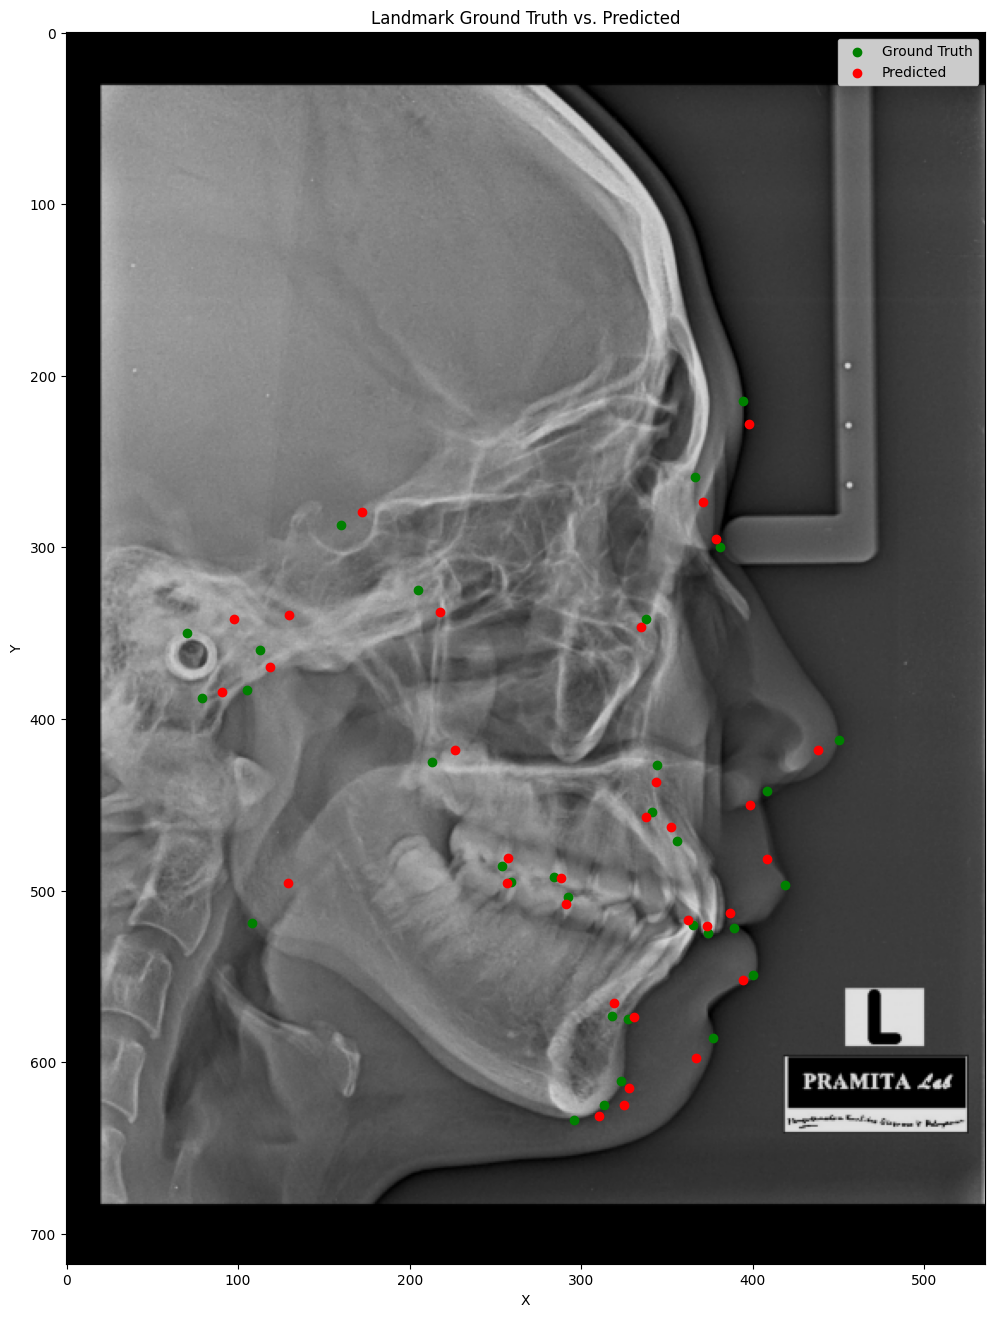

In [30]:
# Menghitung rata-rata Euclidean distance
def mean_euclidean_distance2(x_coords_true, y_coords_true, x_coords_pred, y_coords_pred):
    # Menghitung rata-rata Euclidean distance
    distances = np.sqrt((x_coords_true - x_coords_pred) ** 2 + (y_coords_true - y_coords_pred) ** 2)
    return np.mean(distances)

# Data paths
model_path = 'best model/best_model_mre_0.001_adamax.pth'
asli = pd.read_csv('data_annot.csv')

# Visualize predictions
# Misalkan Anda ingin memilih sampel ke-10 dari test dataset
chosen_index = 5  # Ganti dengan indeks yang diinginkan
sample = test_dataset[chosen_index]
sample_index = test_dataset.indices[chosen_index]

file_name = asli.iloc[sample_index]['file_name']
image_path = f'data/images/{file_name}'

predicted_landmarks = prediksi_dan_visualisasikan(image_path, model_path)

# Jika bentuknya (1, 32, 2), perlu direshape
if predicted_landmarks.shape[0] == 1:
    predicted_landmarks = predicted_landmarks.reshape(32, 2)

x_coords_pred = predicted_landmarks[:, 0]
y_coords_pred = predicted_landmarks[:, 1]

# Filter asli untuk file_name yang acak
asli_1 = asli[asli['file_name'] == file_name]
landmark_columns = asli_1.columns[asli_1.columns.str.endswith(('_x', '_y'))]
x_coords_true = asli_1[landmark_columns[landmark_columns.str.endswith('_x')]].values.flatten()
y_coords_true = asli_1[landmark_columns[landmark_columns.str.endswith('_y')]].values.flatten()

# Hitung dan cetak rata-rata Euclidean distance
med = mean_euclidean_distance2(x_coords_true, y_coords_true, x_coords_pred, y_coords_pred)
print(f'Rata-rata Euclidean Distance: {med:.2f}')

# Visualisasi
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(12, 16))
ax.imshow(image)
ax.scatter(x_coords_true, y_coords_true, c='green', label='Ground Truth')
ax.scatter(x_coords_pred, y_coords_pred, c='red', label='Predicted')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Landmark Ground Truth vs. Predicted')
ax.legend()
plt.show()


# EVAL DENGAN MRE

In [29]:
def mean_radial_error(pred, target, pixel_per_mm):
    # Mengganti .view dengan .reshape untuk NumPy arrays
    pred = pred.reshape(-1, 1, 2)
    target = target.reshape(-1, 1, 2)
    error = np.sqrt(np.sum((pred - target) ** 2, axis=2)) / pixel_per_mm
    return error.mean()

def evaluate_model(test_loader, model_path, pixel_per_mm):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    hrnet = create_model('hrnet_w18', pretrained=False)
    hrnet.classifier = nn.Linear(hrnet.classifier.in_features, 32 * 2)

    state_dict = torch.load(model_path, map_location=device)
    state_dict.pop('conv1.weight', None)
    state_dict.pop('conv1.bias', None)
    hrnet.load_state_dict(state_dict, strict=False)

    first_conv_layer = hrnet.conv1
    new_first_conv_layer = nn.Conv2d(1, first_conv_layer.out_channels,
                                     kernel_size=first_conv_layer.kernel_size,
                                     stride=first_conv_layer.stride,
                                     padding=first_conv_layer.padding,
                                     bias=first_conv_layer.bias is not None)
    hrnet.conv1 = new_first_conv_layer

    hrnet.to(device)
    hrnet.eval()

    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for images, landmarks in test_loader:
            images = images.to(device)
            landmarks = landmarks.to(device)
            images = images.squeeze(1)  # Mengubah dari [N, 1, H, W] ke [N, H, W] jika perlu
            outputs = hrnet(images)
            all_outputs.append(outputs.cpu().numpy())
            all_targets.append(landmarks.cpu().numpy())

    all_outputs = np.concatenate(all_outputs, axis=0).reshape(-1, 64)  # Asumsi landmark memiliki 32 pairs x,y
    all_targets = np.concatenate(all_targets, axis=0).reshape(-1, 64)

    mre = mean_radial_error(all_outputs, all_targets, pixel_per_mm)

    df_results = pd.DataFrame({
        'MRE': [mre]
    })

    return df_results


In [30]:
model_paths = [
    'best model/best_model_mre_0.001_adamax.pth',
    'best model/best_model_mse_0.001_adamw.pth',
    'best model/best_model_rmse_0.001_adamw.pth'
]

results = []
for model_path in model_paths:
    df_result = evaluate_model(test_loader, model_path, pixel_per_mm)
    results.append(df_result)

# Gabungkan semua hasil dan visualisasikan
results_df = pd.concat(results, axis=0)
results_df.index = ['MRE 0.001 Adamax', 'MSE 0.001 Adamw', 'RMSE 0.001 Adamw']
results_df


,MRE
MRE 0.001 Adamax,4.536614
MSE 0.001 Adamw,5.202645
RMSE 0.001 Adamw,4.712880


In [ ]:
results_df.plot(kind='bar', figsize=(10, 5))
plt.title('Model Comparison using Mean Euclidean Distance')
plt.ylabel('Mean Euclidean Distance')
plt.show()


In [21]:
mremed = med/pixel_per_mm
print(mremed)

2.9324644174347214


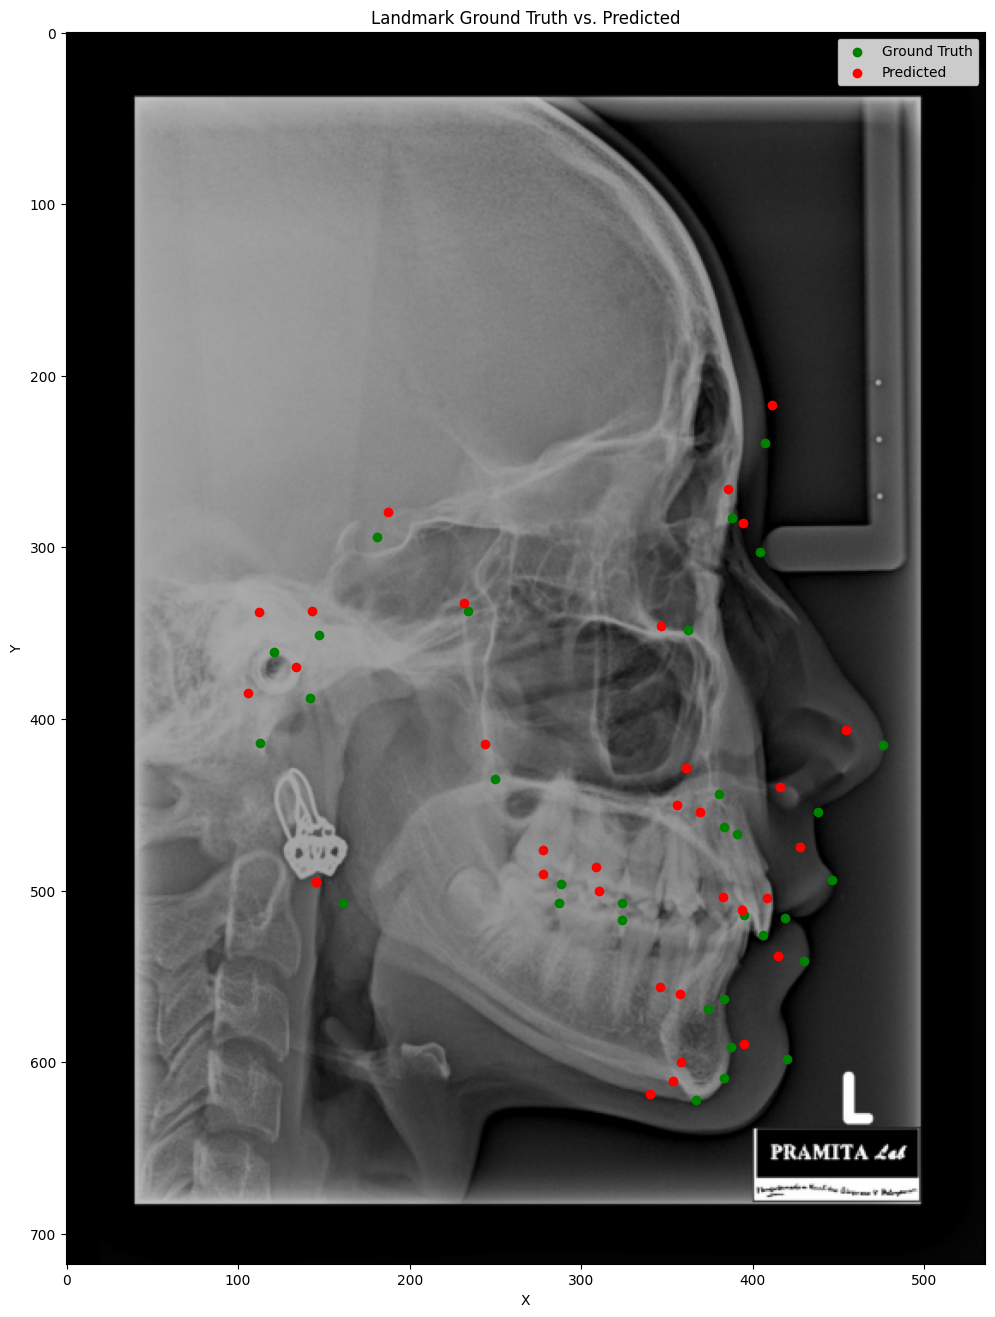

Mean Radial Error (MRE) in mm: 2.83


In [20]:
# # Data paths
model_path = 'best model/best_model_mre_0.001_adamax.pth'
asli = pd.read_csv('data_annot.csv')

# Visualize predictions
# Misalkan Anda ingin memilih sampel ke-10 dari test dataset
chosen_index = 1  # Ganti dengan indeks yang diinginkan
sample = test_dataset[chosen_index]
sample_index = test_dataset.indices[chosen_index]

file_name = asli.iloc[sample_index]['file_name']
image_path = f'data/images/{file_name}'

predicted_landmarks = prediksi_dan_visualisasikan(image_path, model_path)

# Filter asli for the random file_name
asli_1 = asli[asli['file_name'] == file_name]
landmark_columns = asli_1.columns[asli_1.columns.str.endswith(('_x', '_y'))]
x_coords_true = asli_1[landmark_columns[landmark_columns.str.endswith('_x')]].values.flatten()
y_coords_true = asli_1[landmark_columns[landmark_columns.str.endswith('_y')]].values.flatten()
x_coords_pred = predicted_landmarks[0][:, 0]
y_coords_pred = predicted_landmarks[0][:, 1]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(figsize=(12, 16))
ax.imshow(image)
ax.scatter(x_coords_true, y_coords_true, c='g', label='Ground Truth')
ax.scatter(x_coords_pred, y_coords_pred, c='r', label='Predicted')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Landmark Ground Truth vs. Predicted')
ax.legend()
plt.show()

df_true = pd.DataFrame({'x': x_coords_true, 'y': y_coords_true, 'label': 'Ground Truth'})
df_pred = pd.DataFrame({'x': x_coords_pred, 'y': y_coords_pred, 'label': 'Predicted'})
df_combined = pd.concat([df_true, df_pred])

chart = alt.Chart(df_combined).mark_circle(size=100).encode(
    x='x',
    y='y',
    color='label',
    tooltip=['x', 'y', 'label']
).properties(
    title='Landmark Ground Truth vs. Predicted',
    width=800,
    height=600
).interactive()

pixel_per_mm = 7.8

# Calculate Mean Radial Error (MRE) in millimeters
errors_mm = np.sqrt(((x_coords_true - x_coords_pred) / pixel_per_mm) ** 2 +
                    ((y_coords_true - y_coords_pred) / pixel_per_mm) ** 2)
mre_mm = np.mean(errors_mm)
print(f'Mean Radial Error (MRE) in mm: {mre_mm:.2f}')